In [305]:
#Importar librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy import optimize

np.set_printoptions(suppress=True)

In [320]:
# Lectura del dataset
data = pd.read_csv("dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78600 entries, 0 to 78599
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          78600 non-null  object 
 1   hour_of_day        78600 non-null  int64  
 2   sending_address    78600 non-null  object 
 3   receiving_address  78600 non-null  object 
 4   amount             78600 non-null  float64
 5   transaction_type   78600 non-null  object 
 6   location_region    78600 non-null  object 
 7   ip_prefix          78600 non-null  float64
 8   login_frequency    78600 non-null  int64  
 9   session_duration   78600 non-null  int64  
 10  purchase_pattern   78600 non-null  object 
 11  age_group          78600 non-null  object 
 12  risk_score         78600 non-null  float64
 13  anomaly            78600 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 8.4+ MB


In [321]:
#Preprocesamiento de datos
to_convert = ['transaction_type', 'location_region', 'purchase_pattern', 'age_group', 'anomaly']
id2label = {}
label2id = {}
for col in to_convert:
    id2label[col] = {i: cls for i, cls in enumerate(data[col].unique())}
    label2id[col] = {cls: i for i, cls in id2label[col].items()}
    data[col] = data[col].replace(label2id[col])
    print(label2id[col])

num_labels = 3


{'transfer': 0, 'purchase': 1, 'sale': 2, 'phishing': 3, 'scam': 4}
{'Europe': 0, 'South America': 1, 'Asia': 2, 'Africa': 3, 'North America': 4}
{'focused': 0, 'high_value': 1, 'random': 2}
{'established': 0, 'veteran': 1, 'new': 2}
{'low_risk': 0, 'moderate_risk': 1, 'high_risk': 2}


In [322]:
#Selección de las columnas para x y y
x = data.iloc[:, [1, 4, 5, 6, 8, 9, 10, 11, 12]]
y = data.iloc[:, 13]

x = x.to_numpy()
y = y.to_numpy()

print(x)
print(y)

[[ 12.    796.949   0.    ...   0.      0.     18.75 ]
 [ 19.      0.01    1.    ...   0.      0.     25.   ]
 [ 16.    778.197   1.    ...   0.      0.     31.25 ]
 ...
 [ 16.    624.674   1.    ...   2.      2.     36.75 ]
 [  4.    401.392   1.    ...   0.      0.     35.438]
 [ 14.    523.948   0.    ...   0.      0.     15.75 ]]
[0 0 0 ... 0 0 0]


In [262]:
#Normalización de los datos
def featureNormalize(x):
    mu = np.mean(x, axis=0)
    sigma = np.std(x, axis=0)
    x_norm = (x - mu) / sigma
    return x_norm, mu, sigma

x, mu, sigma = featureNormalize(x)
print(x)

[[ 0.067  1.197 -1.185 ... -1.229 -1.229 -1.204]
 [ 1.077 -2.044 -0.239 ... -1.229 -1.229 -0.916]
 [ 0.644  1.121 -0.239 ... -1.229 -1.229 -0.629]
 ...
 [ 0.644  0.497 -0.239 ...  1.226  1.226 -0.377]
 [-1.086 -0.411 -0.239 ... -1.229 -1.229 -0.437]
 [ 0.356  0.087 -1.185 ... -1.229 -1.229 -1.341]]


In [263]:
#Generar set de entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train.shape, x_test.shape

((62880, 9), (15720, 9))

In [264]:
#Función de activación sigmoid
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [294]:
#Función de costo y descenso por el gradiente
def lrCostFunction(theta, x, y, lambda_):
    m = y.size
    h = sigmoid(x.dot(theta.T))
    theta = theta.copy()
    theta[0] = 0
    j = (1 / m) * np.sum(-y.dot(np.log(h + 1e-15)) - (1 - y).dot(np.log(1 - h + 1e-15))) + (lambda_ / (2 * m)) * np.sum(np.square(theta))
    grad = (1 / m) * (h - y).dot(x) 
    grad = grad + (lambda_ / m) * theta
    return j, grad

In [303]:
#Funciin para el cálculo de los valores de theta
def oneVsAll(x, y, num_labels, lambda_):
    m, n = x.shape
    all_theta = np.zeros((num_labels, n + 1))
    x = np.concatenate([np.ones((m, 1)), x], axis=1)
    all_j_history = []
    for c in range(num_labels):
        initial_theta = np.zeros(n + 1)
        j_history = []
        def costFunction(theta, x, y, lambda_):
            j, grad = lrCostFunction(theta, x, y, lambda_)
            j_history.append(j)
            return j, grad
        options = {'maxiter': 50}
        res = optimize.minimize(costFunction,
                                initial_theta,
                                (x, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)
        all_theta[c] = res.x
        all_j_history.append(j_history)
    return all_theta, all_j_history

In [307]:
lambda_ = 0.1
all_theta, all_j_history = oneVsAll(x_train, y_train, num_labels, lambda_)
print(all_theta)

[[ 19.775   0.199  -1.98   -5.857  -0.009   0.18    0.072   2.667   2.667
  -24.777]
 [ -8.578  -0.557   0.881   0.439  -0.028   2.366   0.943  -2.202  -2.202
    5.5  ]
 [-15.251   1.75   -1.042   3.718   0.05   -2.586  -2.188  -1.646  -1.646
    7.17 ]]


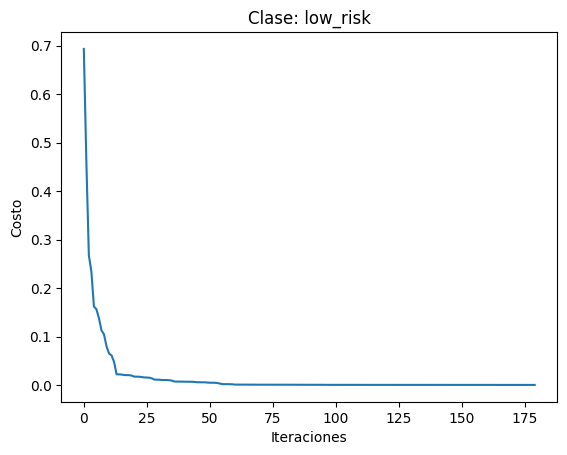

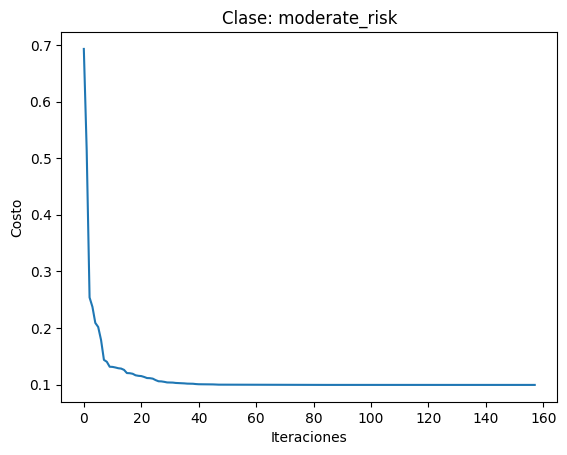

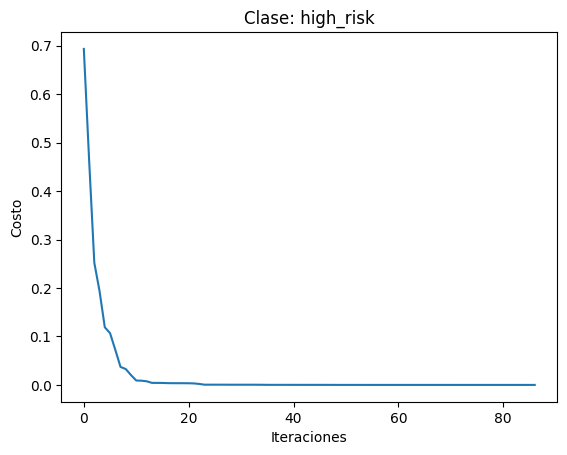

In [315]:
#Graficas de coste de los valores de theta para las distintas clases
for i, j_history in enumerate(all_j_history):
    plt.plot(j_history)
    plt.title(f'Clase: {id2label["anomaly"][i]}')
    plt.xlabel('Iteraciones')
    plt.ylabel('Costo')
    plt.show()

In [316]:
#Función para ejecutar el modelo generado
def predictOneVsAll(all_theta, x):
    m = x.shape[0];
    x = np.concatenate([np.ones((m, 1)), x], axis = 1)
    p = np.argmax(sigmoid(x.dot(all_theta.T)), axis = 1)
    return p

In [319]:
#Ejemplo de las predicciones realizadas por el modelo
p = predictOneVsAll(all_theta, x_test)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(p == y_test) * 100))
x_test_1 = x_test[0:100, :].copy()
p = predictOneVsAll(all_theta, x_test_1)
print("Predicciones:")
print(p)
print("Valores reales:")
print(y_test[0:100])

Precision del conjuto de entrenamiento: 99.44%
Predicciones:
[0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 2 0 1 0 0 0 0 0 0 0 0 0 1 0 2 0 0 1 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0]
Valores reales:
[0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 2 0 1 0 0 0 0 0 0 0 0 0 1 0 2 0 0 1 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0]
